In [1]:
#timings based on cpu-only AMD7600X 32GB Ram (only 16GB accessible in WSL)

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import os
import pickle
import requests
from PIL import Image
from IPython.display import display
import torch
from time import perf_counter
import statistics

In [2]:
# import and set Processor and Model

from transformers import AutoProcessor, VipLlavaForConditionalGeneration

model_id = "llava-hf/vip-llava-7b-hf"

processor = AutoProcessor.from_pretrained("llava-hf/vip-llava-7b-hf")
model = VipLlavaForConditionalGeneration.from_pretrained("llava-hf/vip-llava-7b-hf"
                                                      , torch_dtype=torch.bfloat16
                                                     )
model = torch.compile(model)




/home/jf/micromamba/envs/lava-test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.81s/it]


In [3]:
# defined captioning function

def caption(img):

    question = "Describe this picture."
    prompt = f"The assistant gives helpful, detailed, and polite answers to the human's questions. The human may be visually impaired ###Human: <image>\n{question}###Assistant:"

      
    t_start = perf_counter()
    
    raw_image = img.convert('RGB')
    inputs = processor(prompt, raw_image, return_tensors="pt")
    out = model.generate(**inputs, max_new_tokens=50, do_sample = False)

    caption_txt = processor.decode(out[0][2:], skip_special_tokens=True)  
    
    t_end = perf_counter()
    t_passed = t_end - t_start
    
    return [caption_txt, t_passed]

In [4]:
#set location of client secret file you got from Google Cloud Console and required API scopes

CLIENT_SECRET = 'client_secret.json'
SCOPES = ['https://www.googleapis.com/auth/photoslibrary']

In [5]:
#authenticate and authorize, save token in a .pickle

creds = None
if os.path.exists('token.pickle'):
    with open('token.pickle', 'rb') as token:
        creds = pickle.load(token)

if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
            CLIENT_SECRET, SCOPES)
        creds = flow.run_local_server(port=0)
    with open('token.pickle', 'wb') as token:
        pickle.dump(creds, token)


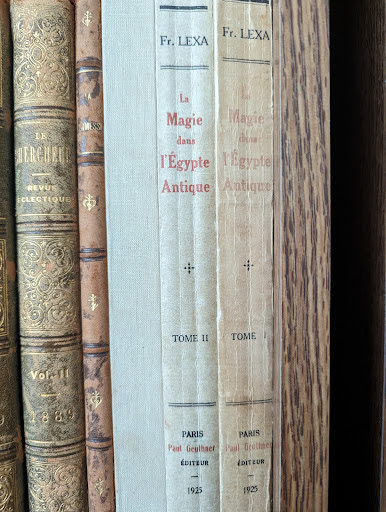

['assistant gives helpful, detailed, and polite answers to the human\'s questions. The human may be visually impaired ###Human: <image> \nDescribe this picture.###Assistant: The image features a bookshelf with a row of books, including a large book titled "La Magie Dans L\'Egypte Ancienne" (The Magic of Ancient Egypt). The book is the largest of the four books', 32.49030278698774]
32.49030278698774


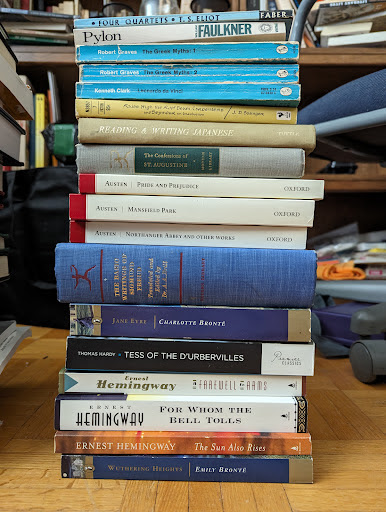

["assistant gives helpful, detailed, and polite answers to the human's questions. The human may be visually impaired ###Human: <image> \nDescribe this picture.###Assistant: The image features a large stack of books, with the top book being a blue one and the bottom one being a white one. The books are arranged in a pile, with some of them being taller than others. The books are of various", 36.3304117040243]
34.41035724550602


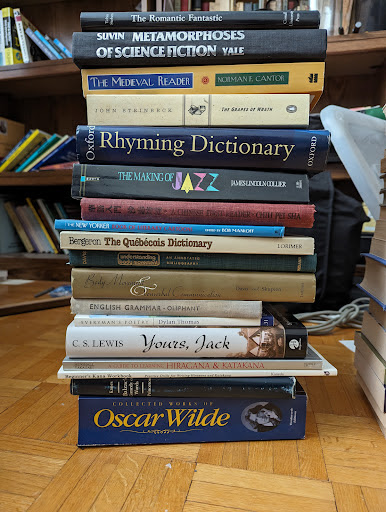

["assistant gives helpful, detailed, and polite answers to the human's questions. The human may be visually impaired ###Human: <image> \nDescribe this picture.###Assistant: The image features a wooden table with a large stack of books on it. The books are arranged in a pile, with some of them being taller than others. The books are of various sizes and colors, indicating a diverse collection. The stack", 32.63211313000647]
33.81760920700617


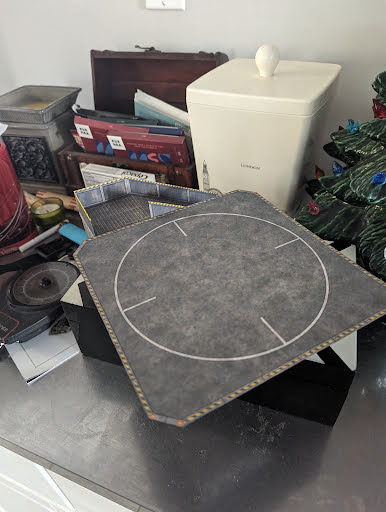

["assistant gives helpful, detailed, and polite answers to the human's questions. The human may be visually impaired ###Human: <image> \nDescribe this picture.###Assistant: The image features a cluttered desk with various items on it. There is a clock sitting on the desk, which is positioned towards the right side of the scene. A box is also present, located towards the left side of the", 32.179793301038444]
33.40815523051424


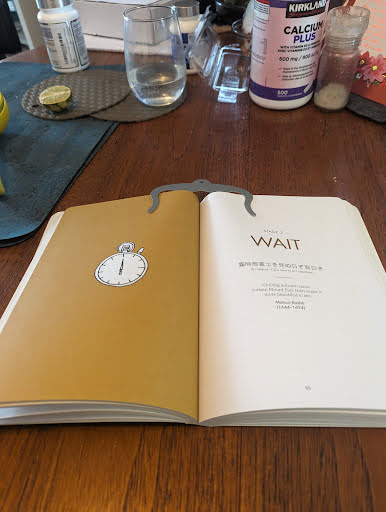

In [ ]:
#get all media item info

response = requests.get('https://photoslibrary.googleapis.com/v1/mediaItems', headers={'Authorization': f'Bearer {creds.token}'})
mediaItems = response.json()['mediaItems']

#loop through all the media items to get each base url and feed it to the captioning model function

baseUrls = []
times = []


for i in mediaItems:
    # baseUrls.append(i['baseUrl'])
    img = Image.open(requests.get(i['baseUrl'], stream=True).raw)
    display(img)
    caption_list = caption(img)
    print(caption_list)
    times.append(caption_list[1])
    print(statistics.fmean(times))
    avg = statistics.fmean(times)

Kernel restarts about this many pages in

In [ ]:
print(avg)